# DRMM (Deep Relevance Matching Model)

_Ismaël Bonneau_


But de ce notebook: Construire une architecture DRMM fonctionnelle avec Keras.

Pour cela, 2 étapes:

- construire la chaîne de pré traitements:
    - générer des paires document-requête non pertinentes et pertinentes pour l'apprentissage
    - générer des histogrammes d'interaction locales au niveau document-requête
- construire l'architecture DRMM

Les interractions sont pour le moment des interactions locales sur des word embeddings et sont mesurées comme une similarité cosinus entre les vecteurs des mots de la requête et ceux du document.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import sep
import os
import random

import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

embeddings_path = "embeddings_wiki2017"
dataset_path = "data"

## Pré traitements: 

### Récupérer des word embeddings 

Ce word embedding a les caractéristiques suivantes:

- FastText Continuous Skipgram
- taille de vecteur ${300}$
- window ${5}$
- entrainé sur wikipédia février 2017 en langue anglaise
- pas de lemmatisation
- ${302815}$ mots

http://vectors.nlpl.eu/repository/

In [4]:
from gensim.models.wrappers import FastText

model = FastText.load_fasttext_format('embeddings_wiki2017/parameters.bin')

In [5]:
model.most_similar("Toulouse")

[('Montpellier', 0.789309024810791),
 ('Toulousain', 0.7702901363372803),
 ('Rennes', 0.7351198792457581),
 ('Carcassonne', 0.7334332466125488),
 ('Perpignan', 0.7310673594474792),
 ('Marseille', 0.7305486798286438),
 ('Narbonne', 0.7292917370796204),
 ('Nantes', 0.7145097255706787),
 ('Castres', 0.7123193740844727),
 ('Poitiers', 0.7071923017501831)]

### On Récupère les paires de pertinence/non pertinence pour chaque requête 

On génère un dictionnaire qui contient pour chaque requête en clé, un dictionnaire contenant 2 listes:
- "relevant" contenant des id de document pertinents pour la requête.
- "irrelevant" contenant des id de document non pertinents pour la requête.

In [2]:
paires = {}

with open(dataset_path + sep + "qrels.robust2004.txt", "r") as f:
    for line in f:
        lol = line.split()
        paires.setdefault(lol[0], {})
        paires[lol[0]].setdefault('relevant', []) 
        paires[lol[0]].setdefault('irrelevant', [])
        if lol[-1] == '1':
            paires[lol[0]]["relevant"].append(lol[2])
        else:
            paires[lol[0]]["irrelevant"].append(lol[2])

### On récupère les requêtes:

Elles se trouvent sous forme de tuple ([mots clés], [texte de la requête]). On ne garde que les mots clés.

In [26]:
import ast
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation

def clean(txt):
    return txt.replace(",", "").replace(".", "")

with open(dataset_path + sep + "robust2004.txt", "r") as f:
    queries = ast.literal_eval(f.read())
queries = {d:clean(queries[d][0]) for d in queries}

In [16]:
print(queries["301"])
print(queries["401"])

international organized crime
foreign minorities germany


### Le DRMM a deux entrées: une entrée interactions et une entrée termes.

L'entrée termes prend un vecteur d'idf des termes de la requête. Il faut donc pouvoir récupérer efficacement des idf. Pour cela, on construit un dictionnaire terme -> idf qui nous servira dans l'étape d'après.

In [3]:
#bon là on charge du coup vu que le fichier est sauvegardé sur le disque
idf = pickle.load(open("idf_robust2004.pkl", "rb"))

In [19]:
import elasticsearch as es

engine = es.Elasticsearch(['localhost:9200'], timeout=30, max_retries=10, retry_on_timeout=True)

### On peut maintenant construire l'histogramme des interactions entre les embeddings de la requête et ceux du document.

On prend comme exemple 4 bins: ${[-1, -0.5]}$ ${[-0.5, 0]}$ ${[0, 0.5]}$ ${[0.5, 1]}$.

**Plusieurs manières de construire un histogramme**: compter le nombre de valeurs, compter puis normaliser...

In [6]:
from load_data import Dataset

inputgenerator = Dataset(intervals=30, model_wv=model)
inputgenerator.load_idf(idf_file="idf_robust2004.pkl")
inputgenerator.load_all_query(file_query="data/robust2004.txt")
inputgenerator.load_relevance(file_rel="data/qrels.robust2004.txt")

query chargé

relevance chargé



In [7]:
inputgenerator.load_all_docs()

docs chargés



In [ ]:
inputgenerator.prepare_data_forNN()

In [3]:
test_size = 0.2

interractions_train = []
interractions_test = []

shapes_train = {}
shapes_test = {}
for id_requete in paires:
    if id_requete != '634':
        saintjeanlapuenta = np.load("saved_data/{}_interractions.npy".format(id_requete))
        if random.random() < test_size:
            interractions_test.append(saintjeanlapuenta)
            shapes_test[id_requete] = saintjeanlapuenta.shape[0]
        else:
            interractions_train.append(saintjeanlapuenta)
            shapes_train[id_requete] = saintjeanlapuenta.shape[0]
interractions_train = np.array(interractions_train)
interractions_test = np.array(interractions_test)

In [4]:
print(interractions_train.shape, interractions_test.shape)

(205,) (43,)


In [5]:
interractions_train = np.concatenate([interractions_train[i] for i in range(interractions_train.shape[0])])
interractions_test = np.concatenate([interractions_test[i] for i in range(interractions_test.shape[0])])

In [6]:
print(interractions_train.shape, interractions_test.shape)

(26648, 5, 30) (6114, 5, 30)


In [7]:
query_idf = pickle.load(open("saved_data/query_idf.pkl", "rb"))

idf_vec_train = []
idf_vec_test = []

for id_requete in shapes_train:
    idf_vec_train.append(np.tile(query_idf[id_requete],(shapes_train[id_requete],1)))
for id_requete in shapes_test:
    idf_vec_test.append(np.tile(query_idf[id_requete],(shapes_test[id_requete],1)))
    
idf_vec_train = np.array(idf_vec_train)
idf_vec_test = np.array(idf_vec_test)

In [8]:
idf_vec_train = np.concatenate([idf_vec_train[i] for i in range(idf_vec_train.shape[0])])
idf_vec_test = np.concatenate([idf_vec_test[i] for i in range(idf_vec_test.shape[0])])

In [9]:
print(idf_vec_train.shape, idf_vec_test.shape)

(26648, 5) (6114, 5)


In [10]:
input_label_train = np.zeros(idf_vec_train.shape[0])
input_label_train[::2] = 1
input_label_test = np.zeros(idf_vec_test.shape[0])
input_label_test[::2] = 1

In [11]:
print(input_label_train.shape, input_label_test.shape) #ti as compris

(26648,) (6114,)


## Architecture du modèle

## avec Keras

OU ALORS utiliser matchzoo

In [84]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Activation, Lambda, Permute, merge
from keras.layers import Reshape, Dot
from keras.activations import softmax


def build_keras_model(params):
    """
    """
    
    initializer_interactions = keras.initializers.RandomUniform(minval=-0.1, maxval=0.1, seed=11)
    initializer_gating = keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=11)
    
    #input interactions
    interactions = Input(name='interactions', shape=(params['query_term_maxlen'], params['hist_size']))
    
    #input des term vectors de la query
    query = Input(name='term_vector', shape=[params['query_term_maxlen']])

    #partie feed forward
    z = interactions
    for i in range(len(params['hidden_sizes'])):
        z = Dense(params['hidden_sizes'][i], kernel_initializer=initializer_interactions, name="dense_layer_{}".format(i))(z)
        z = Activation('tanh', name="activation_of_layer_{}".format(i))(z)

    z = Permute((2, 1))(z)
    z = Reshape((params['query_term_maxlen'],))(z)

    #la partie term gating
    q_w = Dense(1, kernel_initializer=initializer_gating, use_bias=False, name="gating_W")(query)
    q_w = Lambda(lambda x: softmax(x, axis=1), output_shape=(params['query_term_maxlen'],))(q_w)
    #q_w = Reshape((params["query_term_maxlen"],))(q_w)

    # combination of softmax(query term idf) and feed forward result per query term
    out_ = Dot(axes=[1, 1], name='s')([z, q_w])

    model = Model(inputs=[query, interactions], outputs=[out_])

    return model

# from https://github.com/faneshion/MatchZoo/blob/master/matchzoo/losses/rank_losses.py
from keras.backend import tf
from keras.losses import *
from keras.layers import Lambda
# y_true is IGNORED (!), you don't have to set a label to train (?)
# y_pred contains the complete batch (!)
#  -> the slicing splits the tensors in even and odd (pos and negative from the input)
#  -> VERY IMPORTANT: The input data must not be shuffled !! shuffle = False

def rank_hinge_loss(y_true, y_pred):

    y_pos = Lambda(lambda a: a[::2, :], output_shape= (1,))(y_pred)
    y_neg = Lambda(lambda a: a[1::2, :], output_shape= (1,))(y_pred)
    
    loss = K.maximum(0., 1. + y_neg - y_pos)
    return K.mean(loss)

#du coup pour l'entrainement dans le batch il faut aligner des paires de doc de la forme 
#positif-négatif-positif-négatif... etc

In [114]:
params = {
    "hidden_sizes": [30, 128, 64, 16, 1],
    "hist_size": 30,
    "query_term_maxlen": 5,
    "embedding_size": 300
}

drmm = build_keras_model(params)
drmm.compile(loss=rank_hinge_loss, optimizer='adam')

In [115]:
drmm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
interactions (InputLayer)       (None, 5, 30)        0                                            
__________________________________________________________________________________________________
dense_layer_0 (Dense)           (None, 5, 30)        930         interactions[0][0]               
__________________________________________________________________________________________________
activation_of_layer_0 (Activati (None, 5, 30)        0           dense_layer_0[0][0]              
__________________________________________________________________________________________________
dense_layer_1 (Dense)           (None, 5, 128)       3968        activation_of_layer_0[0][0]      
__________________________________________________________________________________________________
activation

In [118]:
history = drmm.fit([idf_vec_train, interractions_train], input_label_train, 
                   validation_data=[[idf_vec_test, interractions_test], input_label_test],
                   batch_size=50, verbose=False, shuffle=False, epochs=300)

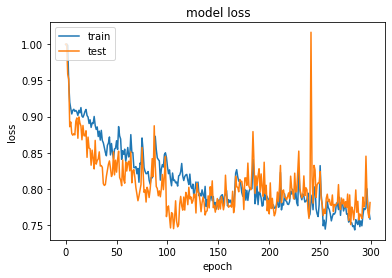

In [119]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Avec pytorch

In [12]:
import torch

In [93]:
class DRMM(torch.nn.Module):
    def __init__(self, hist_size, query_term_maxlen, hidden_sizes=[128,64,16,1], use_cuda=True):
        
        if hidden_sizes[-1] != 1:
            raise ValueError("la taille du dernier layer doit être 1")
            
        super(DRMM, self).__init__()
        self.MLP = [torch.nn.Linear(hist_size, hidden_sizes[0])] + [
            torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]) for i in range(1, len(hidden_sizes))]
        for i in range(len(self.MLP)):
            torch.nn.init.xavier_normal_(self.MLP[i].weight, gain = torch.nn.init.calculate_gain('tanh'))
            
        #initialisation du vecteur de term gating
        self.termgating = torch.nn.Linear(query_term_maxlen, query_term_maxlen, bias=False)
        torch.nn.init.xavier_normal_(self.termgating.weight, gain = torch.nn.init.calculate_gain('tanh'))
        
    def forward(self, interractions, termvector):
        
        #partie histogramme
        interractions_output = self.MLP[0](interractions)
        interractions_output = torch.nn.functional.tanh(interractions_output)
        for layer in self.MLP[1:]:
            interractions_output = layer(interractions_output)
            interractions_output = torch.nn.functional.tanh(interractions_output)
        interractions_output = interractions_output.squeeze()
        
        #partie term gating 
        gating_output = torch.nn.functional.softmax(self.termgating(termvector)).squeeze()
        
        #combiner les 2 avec un produit scalaire
        s = torch.sum(interractions_output * gating_output, dim = 0)
        
        return s

    
class HingeLoss(torch.nn.Module):
    """
        Hinge Loss
          max(0, 1-x+y)
    """
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, x, y):
        output = 1 - x + y
        return output.clamp(min = 0).mean()
    
    
def get_model_size(model):
    return sum([ p.size(0) if len(p.size()) == 1 else p.size(0)*p.size(1) for p in model.parameters()])

In [86]:
from torch.autograd import Variable

def prout(x):
    return Variable(torch.from_numpy(x).type(torch.float))

In [94]:
drmm = DRMM(30,5)

print(drmm.state_dict())

hingeloss = HingeLoss()
optimizer = torch.optim.Adam(drmm.parameters(), lr = 0.0005)

score_pos = drmm(prout(interractions_train[0]), prout(idf_vec_train[0]))
score_neg = drmm(prout(interractions_train[1]), prout(idf_vec_train[1]))

loss = hingeloss(score_pos, score_neg)
loss.backward()
optimizer.step()

print(drmm.state_dict())

OrderedDict([('termgating.weight', tensor([[-0.8218, -0.7770,  1.4140, -0.1482,  0.6942],
        [ 0.3305, -0.7004,  0.5262,  0.2444,  0.2013],
        [-0.3030,  0.0392, -0.8931, -0.7264,  0.6763],
        [ 0.0644,  0.8886,  0.5998, -0.6017, -0.7318],
        [ 0.0808, -1.2730,  0.1205, -0.5632, -0.5161]]))])
OrderedDict([('termgating.weight', tensor([[-0.8213, -0.7765,  1.4145, -0.1477,  0.6947],
        [ 0.3300, -0.7009,  0.5257,  0.2439,  0.2008],
        [-0.3026,  0.0397, -0.8926, -0.7261,  0.6766],
        [ 0.0639,  0.8881,  0.5993, -0.6022, -0.7323],
        [ 0.0808, -1.2730,  0.1204, -0.5633, -0.5161]]))])


/home/ismael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

net = DRRM()#.cuda()
loss = HingeLoss()
optimizer = optim.Adam(net.parameters(), learning_rate = 0.0005)
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(X,0):
        query, docs = data
            
            
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])